In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")
llm.invoke("Do you know vivek pudur").content

"<think>\n\n</think>\n\nAs of my last update in July 2024, I don't have specific information about an individual named Vivek Pudur. It's possible that Vivek Pudur could be a private individual or someone who has gained prominence after my last update. If you have more context or details about Vivek Pudur, I might be able to provide more general information or help with related topics. Let me know how I can assist!"

In [9]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b


In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()
search.invoke("Vivek Pudur, GSK Lead Product designer")

"GSK R&D is led by science. Science is driving an ever-increasing variance and complexity of Clinical Research, and its related approaches to medicines development, trial design and engagement with ... GSK R&D is led by science and is extending our portfolio of products at pace with ever-increasing variance and complexity. R&D Tech has a critical part to play in building modern digital and data ... GSK's business development team have been working overtime of late, with three R&D deals announced in the last few days across Alzheimer's disease and cancer. Oversee product design roadmap and design sprint (s). Lead the validation of product concept effectively by developing prototypes and interactive mockups with scientific customers and engineers. Collaborate with product managers to define requirements, prioritize features, and iterate design solutions. Abstracts for Round Table (RT) Session 4: Biologics/Long Acting Injectables Moderators: Dimple Modi and Veeran Kadajji Presentation 1 D

In [10]:
tools = [multiply, add, divide, search]

In [11]:
llm_with_tools = llm.bind_tools(tools)

In [23]:
response = llm_with_tools.invoke("what is current price of GSK Stock")

In [24]:
response.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'current price of GSK Stock'},
  'id': '3j74hpahy',
  'type': 'tool_call'}]

In [25]:
SYSTEM_PROMPT="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
user_query=["tell me what is 2+2"]


In [26]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START


In [30]:
def function_1 (state: MessagesState):
    user_question = state["messages"]
    input_question = [SYSTEM_PROMPT]+user_question
    response = llm_with_tools.invoke(input_question) 
    return {"messages": response}

In [31]:
builder = StateGraph(MessagesState)

In [32]:
builder.add_node("llm_decision_step",function_1)

In [33]:
from langgraph.prebuilt import ToolNode
builder.add_node("tools",ToolNode(tools))

In [34]:
builder.add_edge(START,"llm_decision_step")


In [35]:
from langgraph.prebuilt import tools_condition
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)

In [36]:
builder.add_edge("tools","llm_decision_step")


In [37]:
react_graph=builder.compile()


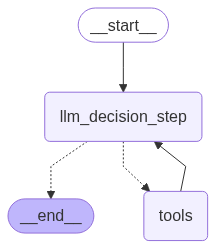

In [38]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [47]:
message=[HumanMessage(content="How many titles did CSK won and divide the number by 2?")]

In [48]:
response = react_graph.invoke({"messages":message})

In [49]:
for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

How many titles did CSK won and divide the number by 2?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (0cdtpf73t)
 Call ID: 0cdtpf73t
  Args:
    query: Chennai Super Kings titles won
================================= Tool Message =================================
Name: duckduckgo_search

List of Chennai Super Kings records Chennai Super Kings (CSK) are an Indian franchise cricket team based in Chennai, Tamil Nadu which plays in the Indian Premier League (IPL). Founded in 2008 this team led by Dhoni. The team plays its home matches at the M. A. Chidambaram Stadium in Chennai. Check out the ranking of all five Chennai Super Kings IPL title wins, featuring emotional moments and iconic performances in the league's history, only on CricTracker. A total of 10 teams participate in the tournament, with multiple teams securing the title over the y

In [51]:
import yfinance as yf

In [52]:
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"
     

In [53]:
get_stock_price.invoke("AAPL")


'The last closing price of AAPL was $201.08.'

In [54]:
tools = [add, multiply, divide, search,get_stock_price]

In [55]:
llm_with_tools=llm.bind_tools(tools)


In [ ]:
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }


In [56]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_decision_step", function_1)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "llm_decision_step")
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
workflow.add_edge("tools", "llm_decision_step")
react_graph2 = workflow.compile()

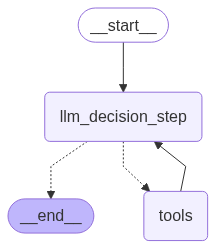

In [57]:
display(Image(react_graph2.get_graph(xray=True).draw_mermaid_png()))


In [59]:
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]


In [60]:
messages = react_graph2.invoke({"messages": messages})


In [61]:
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (8r383s43s)
 Call ID: 8r383s43s
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $205.17.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (xcaaxb13q)
 Call ID: xcaaxb13q
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $205.17.
================================== Ai Message ==================================

The current stock price of Apple (AAPL) is $205.17. Adding 1000 to this price results in:

$205.17 + 1000 = $1205.17

**Answer:** $1205.17


Assignment:
    
AI Travel Agent & Expense Planner(Purpose: Trip planning for any city worldwide with Realtime data.")

• Real-time weather information
• Top attractions and activities
• Hotel cost calculation (per day × total days)
• Currency conversion to user's native currency
• Complete itinerary generation
• Total expense calculation
• generate a summary of the entire output

user_input
  |
search attraction and activity
1. search attracation
2. search restaurant
3. search activity
4. search transportation
  |
search weather forcasting
1. get current weather
2. get weather forcast
  |
search hotel costs
1. search hotel
2. estimate the hotel cost
3. budget_range
  |
calculate total cost
1. add
2. multiply
3. calculated total cost
4. calcualte the daily budget
    | 
currency_converion
1. get exchnage rate
2. convert currancy
    | 
Itinery generation
1. get day plan
2. crete full itinery
    |
create Trip Summary
    |
Retun complete traval plan

Note: if you know the OOPS then design this entire system using object and class in modular fashion.


deadline is till next friday 9PM IST


 everyone you can submit the assignments in this form. MAke sure to have one GitHub link and put all the assignments there https://forms.gle/g8RZ4qx8yvNcih4B7    
        